<a href="https://colab.research.google.com/github/anuxcr/-Hypertension-Prediction-Model-Hypertension-Prediction-Model_/blob/main/Hypertension_Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset loaded successfully.

Dataset Head:
   Age  Salt_Intake  Stress_Score       BP_History  Sleep_Duration   BMI  \
0   69          8.0             9           Normal             6.4  25.8   
1   32         11.7            10           Normal             5.4  23.4   
2   78          9.5             3           Normal             7.1  18.7   
3   38         10.0            10     Hypertension             4.2  22.1   
4   41          9.8             1  Prehypertension             5.8  16.2   

      Medication Family_History Exercise_Level Smoking_Status Has_Hypertension  
0            NaN            Yes            Low     Non-Smoker              Yes  
1            NaN             No            Low     Non-Smoker               No  
2            NaN             No       Moderate     Non-Smoker               No  
3  ACE Inhibitor             No            Low     Non-Smoker              Yes  
4          Other             No       Moderate     Non-Smoker               No  

Dataset Info

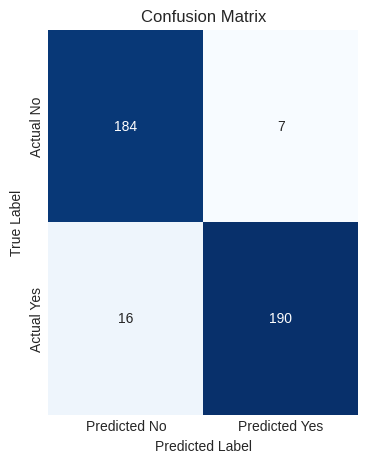

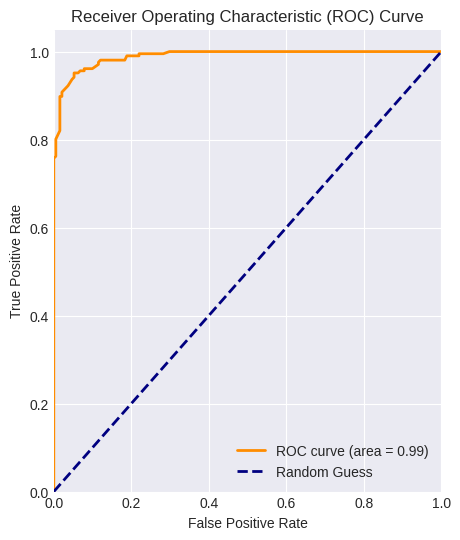

/tmp/ipython-input-3-108468523.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(15), palette='viridis') # Show top 15 features


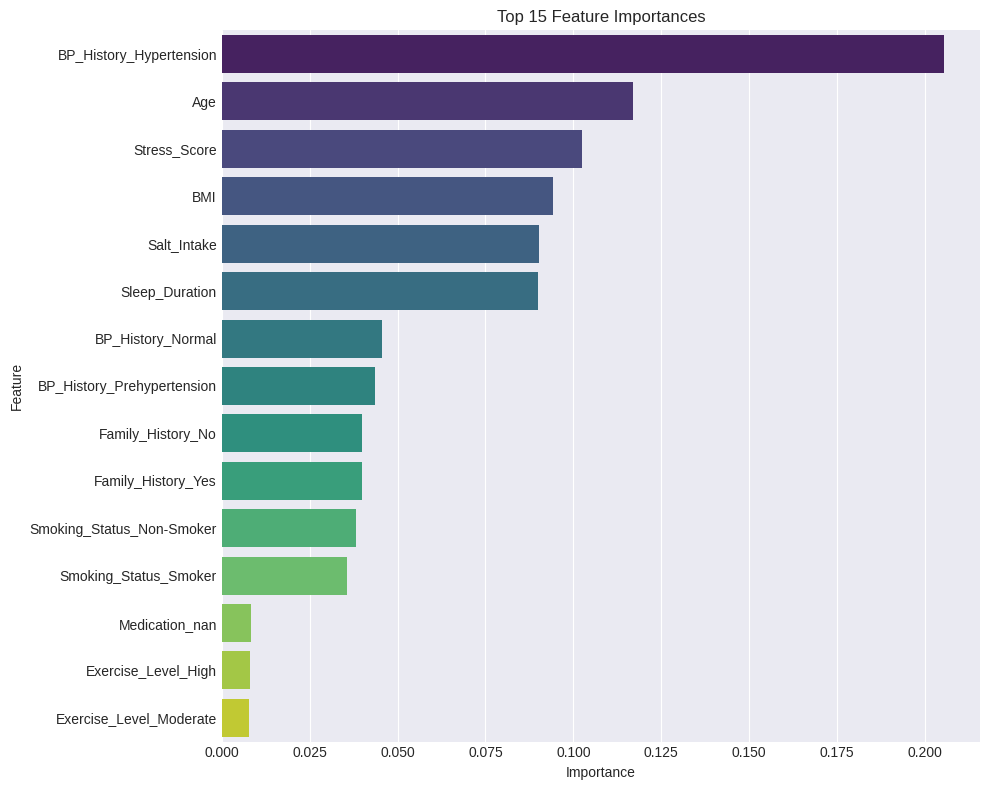


Demonstrating a prediction on a sample data point:
Sample Data: {'Age': 60, 'Salt_Intake': 9.0, 'Stress_Score': 7, 'BP_History': 'Hypertension', 'Sleep_Duration': 6.5, 'BMI': 26.0, 'Medication': 'ACE Inhibitor', 'Family_History': 'Yes', 'Exercise_Level': 'Moderate', 'Smoking_Status': 'Smoker'}
Predicted Outcome: Has Hypertension
Prediction Probabilities (No Hypertension, Has Hypertension): [0. 1.]


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
try:
    df = pd.read_csv('hypertension_dataset.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'hypertension_dataset.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Display the first few rows and column information to understand the data
print("\nDataset Head:")
print(df.head())
print("\nDataset Info:")
df.info()
print("\nDataset Description:")
print(df.describe(include='all'))

# Separate features (X) and target (y)
X = df.drop('Has_Hypertension', axis=1)
y = df['Has_Hypertension']

# Convert target variable 'Yes'/'No' to 1/0
y = y.map({'Yes': 1, 'No': 0})

# Identify categorical and numerical features
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler() # Scale numerical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # One-hot encode categorical features

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline with preprocessing and a classifier
# Using RandomForestClassifier as it's a robust choice for many classification tasks
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])

# Split data into training and testing sets
# Using a 80/20 split for training/testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Train the model
print("\nTraining the model...")
model.fit(X_train, y_train)
print("Model training complete.")

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilities for the positive class (Has_Hypertension)

# Evaluate the model
print("\nModel Evaluation:")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Hypertension', 'Has Hypertension']))
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# --- Visualization Section ---
plt.style.use('seaborn-v0_8-darkgrid') # Set a nice style for plots

# 1. Confusion Matrix Heatmap
plt.figure(figsize=(4, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 2. ROC Curve and AUC Score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 3. Feature Importances
# Get feature names after one-hot encoding
ohe_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Get feature importances from the RandomForestClassifier
importances = model.named_steps['classifier'].feature_importances_
feature_importances_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(15), palette='viridis') # Show top 15 features
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


# Example of making a prediction on new data (demonstration purposes)
# You would replace this with actual new data for real-world predictions
print("\nDemonstrating a prediction on a sample data point:")
sample_data = pd.DataFrame([[60, 9.0, 7, 'Hypertension', 6.5, 26.0, 'ACE Inhibitor', 'Yes', 'Moderate', 'Smoker']],
                           columns=X.columns)

# Make prediction
sample_prediction = model.predict(sample_data)
sample_prediction_proba = model.predict_proba(sample_data)

predicted_outcome = 'Has Hypertension' if sample_prediction[0] == 1 else 'No Hypertension'
print(f"Sample Data: {sample_data.iloc[0].to_dict()}")
print(f"Predicted Outcome: {predicted_outcome}")
print(f"Prediction Probabilities (No Hypertension, Has Hypertension): {sample_prediction_proba[0]}")

# You can save the trained model for future use if needed
# import joblib
# joblib.dump(model, 'hypertension_model.pkl')
# print("\nModel saved as 'hypertension_model.pkl'")